# Notebook 2 — Heston Model as a State-Space Model + Bootstrap Particle Filter

**Goal of this notebook**

- Write the **Heston stochastic volatility model** in **discrete-time, state-space form**.
- Implement it using **Chopin's `particles` library** as a `StateSpaceModel`.
- Run a **bootstrap particle filter** to:
  - Estimate the *hidden variance path* \( V_t \) from returns.
  - Compute an *approximate log-likelihood* for a fixed parameter vector \( \theta \).

This corresponds to **Step 1** of the project:

> Implement a bootstrap filter to approximate the likelihood for given parameter vector θ.

We will start with:
- **Synthetic data** (simulated returns), so we can check if the filter roughly reconstructs the true volatility.
- Later, we will replace synthetic data with **S&P 500 data** and move to **parameter estimation**.


In [24]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')  # avoid clutter

import numpy as np
import matplotlib.pyplot as plt

import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles.collectors import Moments

plt.style.use('ggplot')

print("particles version:", particles.__version__)


particles version: 0.3alpha


## 1. Heston model recap 

Continuous-time Heston model under the risk-neutral measure (simplified):

$$
\begin{aligned}
dS_t &= r S_t \, dt + \sqrt{V_t}\, S_t\, dW_1(t), \\
dV_t &= \kappa(\theta - V_t)\, dt + \sigma \sqrt{V_t}\, dW_2(t),
\end{aligned}
$$

with:
- $S_t$: asset price  
- $V_t$: variance (hidden / latent)  
- $r$: risk-free rate  
- $\kappa$: mean-reversion speed of variance  
- $\theta$: long-run variance  
- $\sigma$: vol of vol  
- $(W_1, W_2)$: Brownian motions with correlation $\rho$

We only **observe prices**, not $V_t$.

So we typically work with **log-returns**:

$$
R_t = \log S_t - \log S_{t-1}
$$

---

## 2. Discretisation (simple Euler scheme)

We consider discrete times $t = 0, \Delta t, 2\Delta t, \dots$.

We’ll use a **standard Euler discretisation** of the Heston SDE.

### 2.1 Variance dynamics (CIR process)

$$
V_t = V_{t-1} 
      + \kappa (\theta - V_{t-1}) \Delta t 
      + \sigma \sqrt{V_{t-1}\Delta t}\,\varepsilon_{2,t},
$$

where  
$\varepsilon_{2,t} \sim N(0,1)$.

### 2.2 Observation equation (log-returns)

Approximate:

$$
R_t \mid V_{t-1} \sim 
N\!\left(\left(r - \tfrac{1}{2}V_{t-1}\right)\Delta t,\;
       V_{t-1}\Delta t\right)
$$

(Using $V_{t-1}$ vs $V_t$ is a discretisation choice; both appear in the literature.)

---

## 3. State-space model structure

We choose the **state** as:

$$
X_t = V_t
$$

and the **observation** as:

$$
Y_t = R_t
$$

So the state-space model is:

- **State transition**  
  $$
  X_t \mid X_{t-1} 
  \sim \text{Euler-CIR}(X_{t-1})
  $$

- **Observation model**  
  $$
  Y_t \mid X_{t-1}
  \sim N\!\left((r - 0.5 X_{t-1})\Delta t,\; X_{t-1}\Delta t\right)
  $$

We will implement this model using Chopin’s `particles` library:

```python
class HestonSSM(ssm.StateSpaceModel):
    def PX0(self): ...
    def PX(self, t, xp): ...
    def PY(self, t, xp, x): ...


# Why Are the Heston Transition and Observation Distributions Normal?

To understand why the particle filter uses **Normal distributions** for both:

- the volatility transition \( V_t \mid V_{t-1} \), and  
- the return distribution \( R_t \mid V_{t-1} \),

we need to recall one key fact from stochastic calculus:

---

## 1. Brownian motion increments are Normal

By definition:

$$
W_{t+\Delta t} - W_t \sim N(0, \Delta t).
$$

So we write:

$$
dW_t \approx \sqrt{\Delta t}\, z_t, \qquad z_t \sim N(0,1).
$$

This single fact makes both parts of the Heston model Normal after discretization.

---

## 2. The Heston volatility SDE

The continuous-time volatility process is:

$$
dV_t = \kappa(\theta - V_t)\,dt \;+\; \sigma \sqrt{V_t}\,dW_t.
$$

Apply Euler–Maruyama discretization:

- \( dV_t \approx V_{t+\Delta t} - V_t \)
- \( dW_t \approx \sqrt{\Delta t}\, z_t \)

We get:

$$
V_{t+\Delta t} =
V_t + \kappa(\theta - V_t)\Delta t
+ \sigma \sqrt{V_t \Delta t}\, z_t.
$$

This is of the form:

$$
V_{t+1} = \text{deterministic term} + \text{Normal noise}.
$$

Therefore:

$$
V_{t+1} \mid V_t \sim 
N\!\Big(
V_t + \kappa(\theta - V_t)\Delta t,\;
\sigma^2 V_t \Delta t
\Big).
$$

This is why `PX` returns a Normal distribution.

---

## 3. The Heston return SDE

The paper gives the log-price SDE:

$$
d\ln S_t 
= \left(r - \tfrac12 V_t\right)dt 
+ \sqrt{V_t}\, dW_1(t).
$$

Apply Euler discretization:

$$
R_t = \ln S_t - \ln S_{t-1}
\approx
(r - \tfrac12 V_{t-1})\Delta t
+ \sqrt{V_{t-1}\Delta t}\, z_t.
$$

Since \( z_t \sim N(0,1) \), this is Normal:

$$
R_t \mid V_{t-1} \sim 
N\!\Big(
(r - \tfrac12 V_{t-1})\Delta t,\;
V_{t-1} \Delta t
\Big).
$$

This is why the `PY` method also returns a Normal distribution.

---

## 4. Core Insight

The Normality does **not** come from an assumption.

It comes from:

1. The Heston model being driven by Brownian motion  
2. Euler discretization turning each SDE into:

   $$
   \text{state}_{t+1} = \text{deterministic part} + \text{Gaussian noise}
   $$

3. A deterministic value plus Normal noise is Normal.

---

## 5. Summary

- Brownian motion increments are Normal.  
- Heston volatility and returns both involve Brownian increments.  
- Euler discretization preserves Normality.  
- Therefore:
  - \( V_{t+1} \mid V_t \) is Normal  
  - \( R_t \mid V_{t-1} \) is Normal  
- This is exactly why the particle filter uses:

```python
dists.Normal(loc=mean, scale=std)


In [25]:
class HestonSSM(ssm.StateSpaceModel):
    def __init__(self, kappa, theta, sigma, rho, r, dt, v0):
        super().__init__()
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.r = r
        self.dt = dt
        self.v0 = v0

    def PX0(self):
        return dists.Dirac(self.v0)

    def PX(self, t, xp):
        vp = np.maximum(np.asarray(xp), 1e-12) #necessary because xp would become a scalar when simulating later
        mean = vp + self.kappa * (self.theta - vp) * self.dt
        std  = self.sigma * np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)

    def PY(self, t, xp, x):
        vp = np.maximum(np.asarray(x), 1e-12)
        mean = (self.r - 0.5 * vp) * self.dt
        std  = np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)


In [26]:
heston = HestonSSM(kappa=2.0, theta=0.04, sigma=0.3, rho=-0.7, r=0.04, dt=1/252, v0=0.04)

# Simulate
true_states, raw_data = heston.simulate(100)

# Extract scalars (not arrays!!)
true_states = [v[0] for v in true_states]
data        = [y[0] for y in raw_data]

## Plot simulated hidden volatility and returns

We visualize the simulated variance path `true_states` and the returns `data`
to confirm that the Heston model simulation behaves as expected.


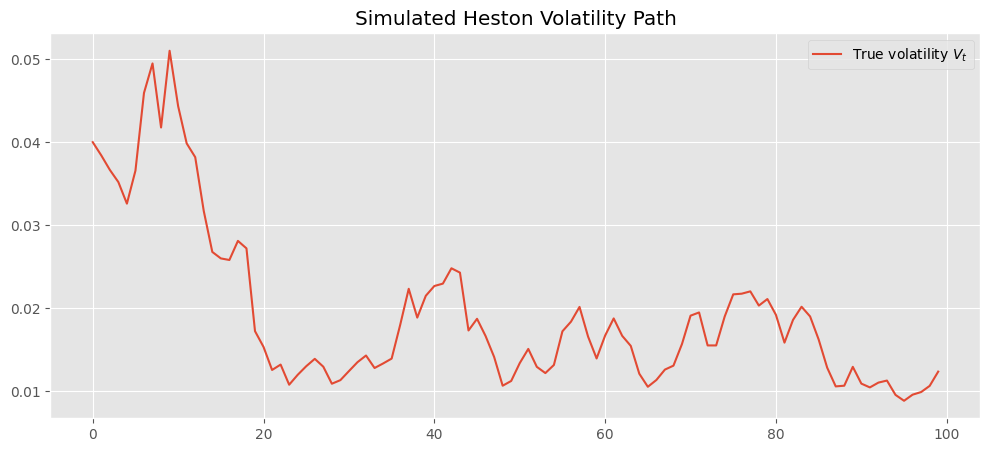

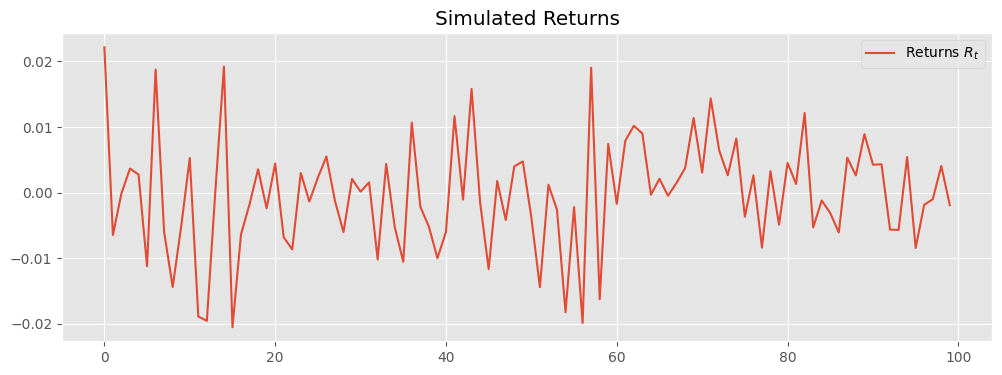

In [27]:
true_states = np.array(true_states).flatten()
data = np.array(data).flatten()

plt.figure(figsize=(12,5))
plt.plot(true_states, label="True volatility $V_t$")
plt.title("Simulated Heston Volatility Path")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(data, label="Returns $R_t$")
plt.title("Simulated Returns")
plt.legend()
plt.show()


## Bootstrap Particle Filter on Synthetic Heston Data

We now run the Bootstrap PF using Chopin's `particles` library.

This PF will:
- sample volatility particles using `PX`
- weight them using `PY`
- resample when ESS gets small
- provide an estimate of the hidden variance
- output an estimated log-likelihood


In [28]:
fk = ssm.Bootstrap(ssm=heston, data=data)

alg = particles.SMC(
    fk=fk,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

alg.run()

print("Estimated log-likelihood:", alg.logLt)


Estimated log-likelihood: 335.9374141141814


# S&P Data

In [48]:
import yfinance as yf
import numpy as np
import pandas as pd

sp500 = yf.download("^GSPC", start="2007-01-01", end="2025-12-31")

# FLATTEN MULTIINDEX COLUMNS
sp500.columns = sp500.columns.droplevel(1)


sp500.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-11-28,6849.089844,6850.859863,6819.750000,6822.520020,2558540000
2025-12-01,6812.629883,6843.649902,6799.939941,6812.299805,4549370000
2025-12-02,6829.370117,6851.549805,6806.709961,6830.959961,4582290000
2025-12-03,6849.720215,6862.419922,6810.430176,6815.290039,4736780000
2025-12-04,6851.310059,6866.470215,6835.169922,6866.470215,1617329000


In [49]:
# Compute log returns directly from Close prices (best practice)
log_returns = np.log(sp500["Close"] / sp500["Close"].shift(1)).dropna()

print("Number of observations:", len(log_returns))
log_returns.head()


Number of observations: 4761


Date
2007-01-04    0.001228
2007-01-05   -0.006103
2007-01-08    0.002218
2007-01-09   -0.000517
2007-01-10    0.001938
Name: Close, dtype: float64

In [81]:
heston2 = HestonSSM(kappa=2.5, theta=0.05, sigma=0.78, rho=-0.6, r=0.04, dt=1/252, v0=0.04)


In [82]:
fk1 = ssm.Bootstrap(ssm=heston2, data=log_returns.values.tolist())

alg = particles.SMC(
    fk=fk1,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

alg.run()

print("Estimated log-likelihood:", alg.logLt)


Estimated log-likelihood: 15365.102324071935


In [83]:
T = len(log_returns)
avg_loglik = alg.logLt / T
T, alg.logLt, avg_loglik


(4761, 15365.102324071935, 3.2272846721428134)

Length PF states: 4761
Length dates: 4761


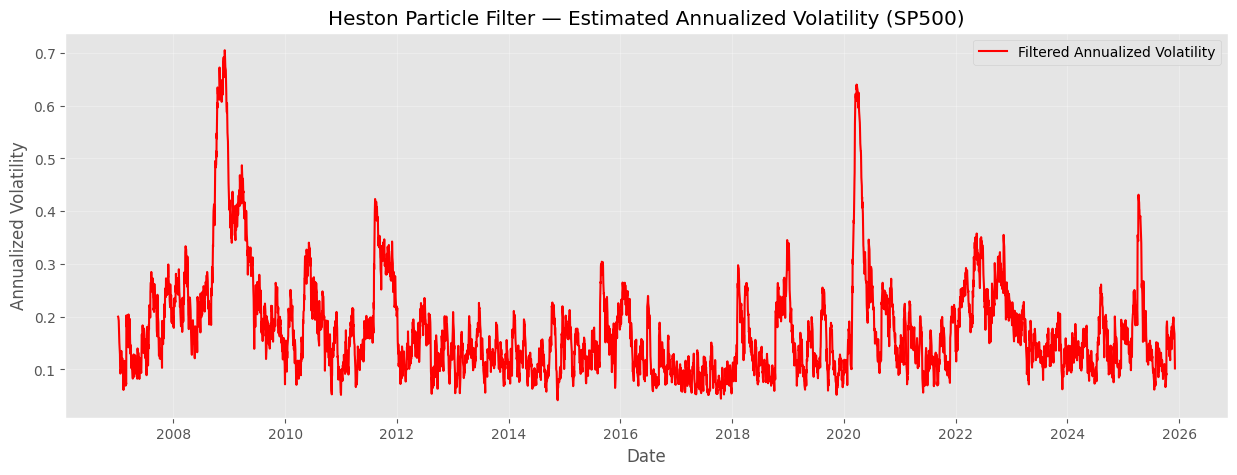

In [84]:
# --- 1. Extract filtered variance from Moments collector ---
pf_filtered_var = np.array([m["mean"] for m in alg.summaries.moments]).flatten()
pf_filtered_var

# --- 2. Convert to volatility ---
pf_vol_annual  = np.sqrt(pf_filtered_var)           # annualized vol

# --- 3. Align dates with PF estimates ---
dates = log_returns.index

# Sanity check
print("Length PF states:", len(pf_filtered_var))
print("Length dates:", len(dates))

# --- 4. Plot Annualized Volatility ---
plt.figure(figsize=(15,5))
plt.plot(dates, pf_vol_annual, color="red", label="Filtered Annualized Volatility")
plt.title("Heston Particle Filter — Estimated Annualized Volatility (SP500)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Length PF states: 4761
Length dates: 4761


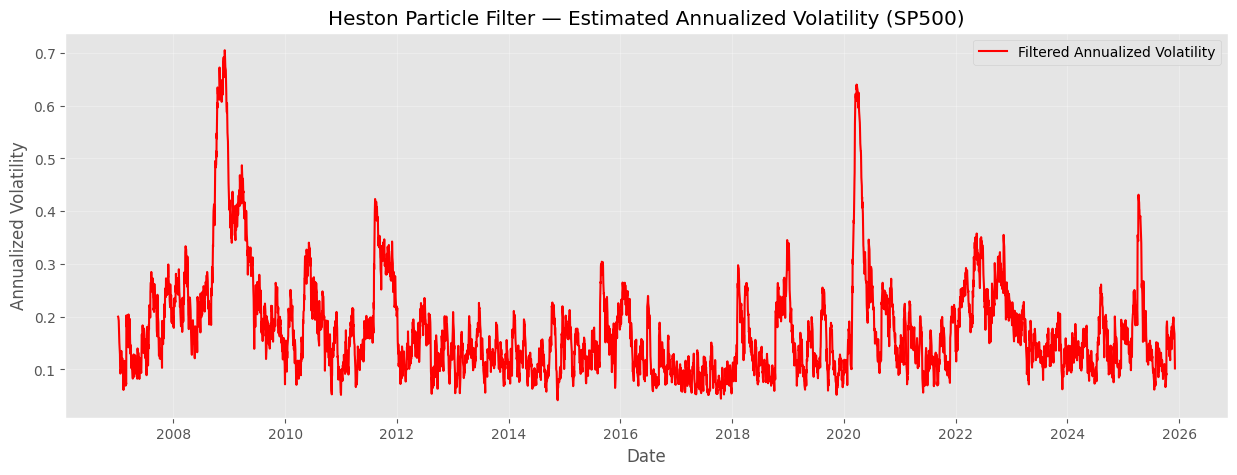

In [85]:

# Sanity check
print("Length PF states:", len(pf_filtered_var))
print("Length dates:", len(dates))

# --- 4. Plot Annualized Volatility ---
plt.figure(figsize=(15,5))
plt.plot(dates, pf_vol_annual, color="red", label="Filtered Annualized Volatility")
plt.title("Heston Particle Filter — Estimated Annualized Volatility (SP500)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


Number of overlapping days: 4760
Correlation PF vs VIX: 0.9058656160930875


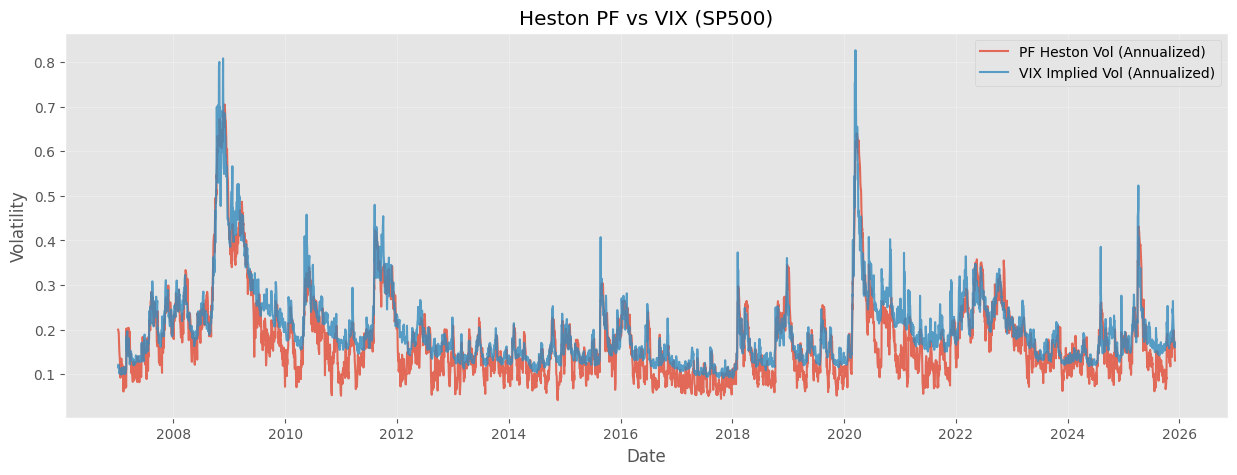

In [86]:
# --- 1. PF volatility (annualized) ---
pf_vol_series = pd.Series(pf_vol_annual, index=log_returns.index, name="PF_AnnualVol")

# --- 2. Download VIX ---
start_date = pf_vol_series.index.min().strftime("%Y-%m-%d")
end_date   = pf_vol_series.index.max().strftime("%Y-%m-%d")

vix = yf.download("^VIX", start=start_date, end=end_date)

# Fix MultiIndex columns (important!)
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = vix.columns.droplevel(1)

# Now this is safe:
vix_series = (vix["Close"] / 100.0).rename("VIX_ImpliedVol")

# --- 3. Merge PF vol + VIX ---
df = pd.concat([pf_vol_series, vix_series], axis=1).dropna()

print("Number of overlapping days:", len(df))
print("Correlation PF vs VIX:", df["PF_AnnualVol"].corr(df["VIX_ImpliedVol"]))

# --- 4. Plot ---
plt.figure(figsize=(15,5))
plt.plot(df.index, df["PF_AnnualVol"], label="PF Heston Vol (Annualized)", alpha=0.8)
plt.plot(df.index, df["VIX_ImpliedVol"], label="VIX Implied Vol (Annualized)", alpha=0.8)
plt.title("Heston PF vs VIX (SP500)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [105]:
n = 21  # window length (e.g., 21 days)

realized_vol = (
    (log_returns**2)
    .rolling(n)
    .mean()
    .apply(np.sqrt)
    * np.sqrt(252)
)
realized_vol.name = "RealizedVol_21d"

In [106]:
df_compare = pd.concat([
    pf_vol_series,
    realized_vol,
    vix_series
], axis=1).dropna()

df_compare.tail()


,PF_AnnualVol,RealizedVol_21d,VIX_ImpliedVol
Date,,,
2025-11-26,0.186428,0.146165,0.1719
2025-11-28,0.176350,0.147331,0.1635
2025-12-01,0.167142,0.144427,0.1724
2025-12-02,0.148464,0.144394,0.1659
2025-12-03,0.130620,0.144638,0.1608


# 📘 Volatility Horizons in Our Comparison

We compare three volatility measures:

- **PF-Heston Volatility** (red)  
- **Realized Volatility (21d)** (blue)  
- **VIX Implied Volatility** (purple)

All three are annualized, but they correspond to **different horizons** and **different probability measures**.

---

## 1. PF-Heston Volatility (Instantaneous, Physical Measure)

The particle filter estimates the latent Heston variance process $V_t$, which represents **daily variance**.

Annualized PF-Heston volatility is:

$$
\sigma^{\text{PF}}_t = \sqrt{252 \, V_t}.
$$

### Horizon
- **Instantaneous (spot)** volatility.  
- Represents volatility **right now**, not over a fixed window.

### Measure
- **Physical measure (P)** — based on historical price dynamics.

---

## 2. Realized Volatility (21-Day Rolling, Physical Measure)

Computed from daily log-returns $r_t$:

$$
\sigma^{\text{real}}_t 
= \sqrt{\frac{252}{21} \sum_{i=t-20}^{t} r_i^2 }.
$$

## 3. VIX (annualized, 21 day forward vol)

VIX is the 1 month (21d) forward looking implied vol obtained form option prices.

​
$$
VIX = \sqrt{\frac{252}{21} ​EQ[30d vol (21 trading days)]}.
$$

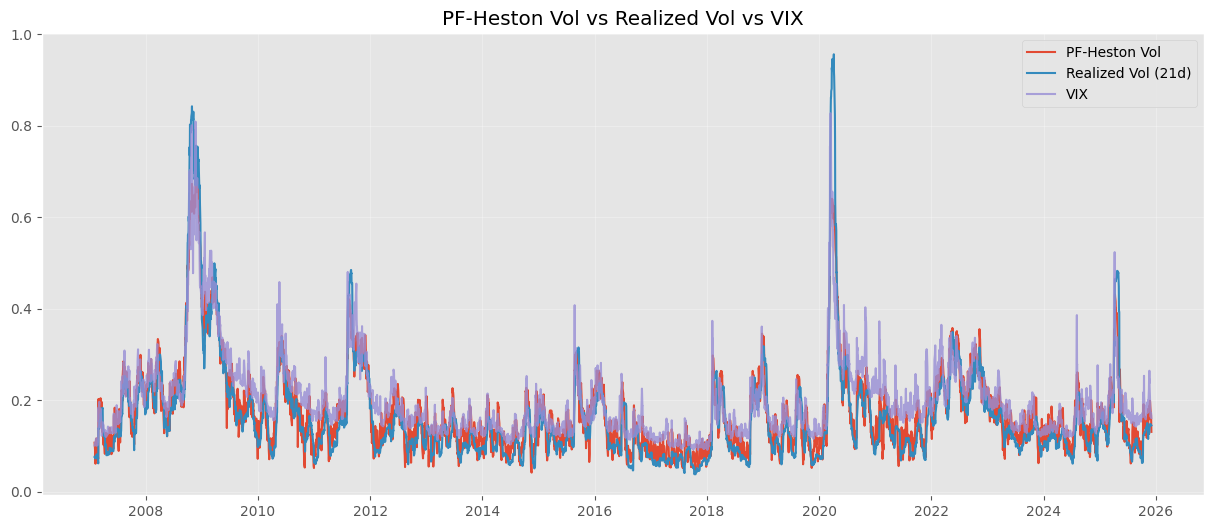

In [107]:
plt.figure(figsize=(15,6))
plt.plot(df_compare.index, df_compare["PF_AnnualVol"], label="PF-Heston Vol")
plt.plot(df_compare.index, df_compare["RealizedVol_21d"], label="Realized Vol (21d)")
plt.plot(df_compare.index, df_compare["VIX_ImpliedVol"], label="VIX", alpha=0.8)

plt.title("PF-Heston Vol vs Realized Vol vs VIX")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
